# 目标
1. 使用 **First Order Motion** 进行人脸表情/动作迁移
    First Order Motion 的任务是图像动画/Image Animation，即输入为一张源图片和一个驱动视频，源图片中的人物则会做出驱动视频中的动作。如下图所示，源图像通常包含一个主体，驱动视频包含一系列动作。
2. 使用 **Wav2Lip** 唇形合成
    Wav2Lip 实现的是视频人物根据输入音频生成与语音同步的人物唇形，使得生成的视频人物口型与输入语音同步。Wav2Lip 不仅可以基于静态图像来输出与目标语音匹配的唇形同步视频，还可以直接将动态的视频进行唇形转换，输出与目标语音匹配的视频。Wav2Lip 实现唇形与语音精准同步突破的关键在于，它采用了唇形同步判别器，以强制生成器持续产生准确而逼真的唇部运动。此外，它通过在鉴别器中使用多个连续帧而不是单个帧，并使用视觉质量损失（而不仅仅是对比损失）来考虑时间相关性，从而改善了视觉质量。Wav2Lip适用于任何人脸、任何语言，对任意视频都能达到很高都准确率，可以无缝地与原始视频融合，还可以用于转换动画人脸。

# 准备工作

In [16]:
# ==============================================
# 如果使用容器运行该实例，忽略此部分内容
# ==============================================

# # Face Cropping
# !wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml" -O "opencv_preconfig/haarcascade_frontalface_alt2.xml" &> /dev/null

# # Wav2Lip
# !git clone "https://github.com/Rudrabha/Wav2Lip.git"
# # download file of model weight by minio-client. [Tips] if you want to get it, you can send email to me. (jiaqianjing1992@163.com)
# !mc cp -r cos/king-1308470969/models/gans/torch/Wav2Lip/face_detection/detection/sfd/s3fd.pth Wav2Lip/face_detection/detection/sfd/
# !mc cp -r cos/king-1308470969/models/gans/torch/Wav2Lip/checkpoints/wav2lip_gan.pth Wav2Lip/checkpoints/

# # First-Order-Model
# !git clone "https://github.com/AliaksandrSiarohin/first-order-model"
# # download file of model weight by minio-client
# !mc cp -r cos/king-1308470969/models/gans/torch/first-order-model/vox-cpk.pth.tar first-order-model/

## 准备数据
1. data/test_01.jpg：原始待改动的图片
2. data/driver_video.mov: 驱动视频，用于学习表情和动作的视频源
3. data/audio.wav: 要合成唇形的语音内容 (其他音频格式亦可,如：iphone 内置录音软件格式 .m4a)
4. data/noise.png：噪点图片

In [25]:
src_img = './data/test_02.jpg'
driver_video = './data/driver_video.mp4'
driver_audio = './data/audio.wav'

In [26]:
import sys
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Audio, HTML
from base64 import b64encode

def show_mp4(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    res = HTML("""
    <video width="640" height="480" controls autoplay="autoplay" preload="auto">
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)
    return res

def show_audio(audio_path):
    return HTML(f"""<audio controls  src="{audio_path}"></audio>""")

In [27]:
show_audio(driver_audio)

source images:


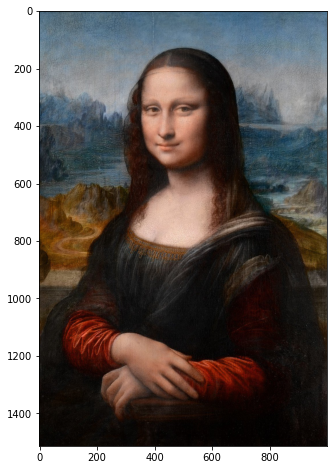

In [28]:
import matplotlib.pyplot as plt
print("source images:")
plt.figure(figsize=(12,8))
plt.imshow(plt.imread(src_img))

In [29]:
show_mp4(driver_video)

# 具体流程

## 待处理图像的人脸检测/截取 【可选操作】
* 注：可以将直接你下载的头像放入 ./first-order-model/data/ 并命名为：img_trimmed.png

[[124  95 109 109]]
trancate face：(189, 189, 3)
./first-order-model/data/img_trimmed.png


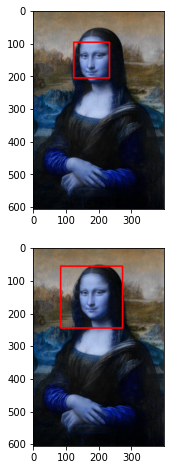

In [30]:
import cv2
import imutils
import copy

plt.figure(figsize=(12,8))
def trim_img(img_src, output_dir='./first-order-model/data'):
    # Read the Input Image
    img = cv2.imread(img_src)
    img = imutils.resize(img, width=400)  

    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # opencv 级联人脸检测 (多尺度检测 detectMultiScale)
    face_cascade = cv2.CascadeClassifier('opencv_preconfig/haarcascade_frontalface_alt2.xml')
    # scaleFactor：每次迭代扫描图片的矩形框缩小比例, 越小计算的越慢相应会检索目标可能会越多，配合 minNeighbors 参数使用
    # minNeighbors: 对于同一个识别的目标（group），在所有迭代后命中的次数，如果少于这个值将被抛弃；minNeighbors=0 将可以看到所有迭代次数后的检测结果
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=2)
    print(faces)
    try:
        for i, (x, y, w, h) in enumerate(faces):
            
            # 直接使用检测后的坐标
            sub_img = plt.subplot(2, len(faces), i+1)
            # sub_img.imshow(img[x:x+w,y:y+h])
            img_cp_01 = copy.deepcopy(img)
            color = (255, 0, 0)
            sub_img.imshow(cv2.rectangle(img_cp_01, (x, y), (x+w, y+h), color, 4))
            
            # 向外扩展检测边缘（40个像素点坐标）
            extention = 40
            f = img[y-extention:y+h+extention, x-extention:x+w+extention]
            print(f"trancate face：{f.shape}")
            sub_img = plt.subplot(2, len(faces), i+1+len(faces))
            # sub_img.imshow(img)
            img_cp_02 = copy.deepcopy(img)
            sub_img.imshow(cv2.rectangle(img_cp_02, (x-extention, y-extention), (x+w+extention, y+h+extention), color, 4))
            
            # 取最后一个检测的结果
            cv2.imwrite(f'{output_dir}/img_trimmed.png', f)
    except:
        print("Error: Face takes too much space on image. Try a different image, or trim it yourself to 400x400.")

    return f"{output_dir}/img_trimmed.png"

if cv2.imread(src_img).shape[0] != cv2.imread(src_img).shape[1]:
    character_img = trim_img(src_img)
    print(character_img)

## 不作人脸截取，直接使用原图进行表情/动作迁移
*注：效果相对于仅有面部图可能会稍差一点, 当上一步人脸检测无结果的时候可以使用该部分内容*

In [31]:
# 不做人脸截取
# !cp -r $src_img ./first-order-model/data/img_trimmed.png

## 表情/动作迁移

In [32]:
import imageio
from skimage.transform import resize
from time import perf_counter

def animate_video(img_filename, video_filename):
    
    start_load_img = perf_counter()
    source_image = imageio.imread(img_filename)
    driving_video = imageio.mimread(video_filename, fps=30, memtest=False) 
    end_load_img = perf_counter()
    print("load image and driver_video spent: %s s" % (end_load_img - start_load_img))
    
    %cd ./first-order-model/
    
    from demo import make_animation
    from demo import load_checkpoints
    from skimage import img_as_ubyte

    # Resize image and video to 256x256
    source_image = resize(source_image, (256, 256))[..., :3]
    driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

    # Load Model
    start_load_model = perf_counter()
    generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', checkpoint_path='./vox-cpk.pth.tar', cpu=False)
    end_load_model = perf_counter()
    print("load model spent: %s s" % (end_load_model - start_load_model))
    
    # Make Animation
    start_process = perf_counter()
    predictions = make_animation(source_image, 
                                 driving_video, 
                                 generator, 
                                 kp_detector, 
                                 relative=True, 
                                 adapt_movement_scale=False,
                                 cpu=False)
    end_process = perf_counter()
    print("process video spent: %s s" % (end_process - start_process))
    
    #save resulting video
    imageio.mimsave('../data/vidvid.mp4', [img_as_ubyte(frame) for frame in predictions], fps=30)

    %cd -

animate_video(character_img, driver_video)

load image and driver_video spent: 5.175839148461819 s
/data1/workspace/research/gans/auto-generated-characters/first-order-model
load model spent: 3.612624179571867 s


100%|██████████| 555/555 [00:22<00:00, 24.92it/s]


process video spent: 25.145345840603113 s
/data1/workspace/research/gans/auto-generated-characters


In [33]:
final_video_driver = './data/vidvid.mp4'
show_mp4(final_video_driver)

## 生成唇形
在执行此步骤前，最好用真实的人物，因为 Wav2Lip 也会取检测人脸，只有被检测到的人脸才能合成唇形
1. troubleshotting
    1. Q: import soundfile 报错：`OSError: sndfile library not found`  
    A: `yum install libsndfile -y` or `apt-get install libsndfile1`
    2. Q: `/bin/sh: ffmpeg`: 未找到命令  
    A: 安装 FFmpeg: https://www.ffmpeg.org/download.html#build-linux

In [34]:
!ffmpeg -version

ffmpeg version 4.4.1-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 8 (Debian 8.3.0-6)
configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
libavutil      56. 70.100 / 56. 70.100
libavcodec     58.134.100 / 58.134.100
libavformat    58. 76.10

In [35]:
# 生成唇形
# 生成视频文件：Wav2Lip/results/result_voice.mp4
%cd Wav2Lip/
!python3 ./inference.py --checkpoint_path "./checkpoints/wav2lip_gan.pth" --face ../$final_video_driver --audio ../$driver_audio
%cd -

/data1/workspace/research/gans/auto-generated-characters/Wav2Lip
Using cuda for inference.
Reading video frames...
Number of frames available for inference: 555
(80, 226)
Length of mel chunks: 81
100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.61it/s]
Load checkpoint from: ./checkpoints/wav2lip_gan.pth
Model loaded
100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.35s/it]
ffmpeg version 4.4.1-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg -

In [36]:
show_mp4("./Wav2Lip/results/result_voice.mp4")

In [37]:
# 给生成的图片打上水印
import moviepy.editor as mp

def traceability(video_filename, watermark_filename):
    video = mp.VideoFileClip(video_filename)
    print("--->", video)

    machine = (mp.ImageClip('data/noise.png')
               .set_duration(video.duration)
               .set_opacity(.05)
               .resize(height = 552) #
               .margin(right = 0, top = 0, opacity = 1.0)
               .set_pos(("center", "center")))
    print("--->", machine)

    human = (mp.ImageClip(watermark_filename)
             .set_duration(video.duration)
             .resize(height = 100) #
             .margin(right = 0, top = 0, opacity = 1.0)
             .set_pos(("left", "bottom")))

    print("--->", human)
    final = mp.CompositeVideoClip([video, machine, human])
    print("--->", final)
    final.write_videofile("data/marked.mp4")


In [38]:
traceability('./Wav2Lip/results/result_voice.mp4', './data/jing.png')

---> <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7f72b75605e0>
---> <moviepy.video.VideoClip.ImageClip object at 0x7f72b75609a0>
---> <moviepy.video.VideoClip.ImageClip object at 0x7f72b7560820>
---> <moviepy.video.compositing.CompositeVideoClip.CompositeVideoClip object at 0x7f72b7560220>
Moviepy - Building video data/marked.mp4.
MoviePy - Writing audio in markedTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video data/marked.mp4



Moviepy - Done !
Moviepy - video ready data/marked.mp4


In [39]:
show_mp4('./data/marked.mp4')